### Twitter Sentiment Investing Strategy

### Imports

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import os
plt.style.use('ggplot')

### 1. Getting Twitter Sentment Data

- Generatintg an investing strategy using twitter engagement ratio, filtering stocks with significant twitter activity

In [104]:
sentiment_df = pd.read_csv('sentiment_data.csv')

sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
sentiment_df = sentiment_df.set_index(['date','symbol'])
sentiment_df['engagement_ratio'] = sentiment_df['twitterComments']/sentiment_df['twitterLikes'] #filtering more enggaging activities, and avoiding bots
sentiment_df = sentiment_df[(sentiment_df['twitterLikes']>20) & (sentiment_df['twitterComments']>10)] #filtering more enggaging activities, and avoiding bots
sentiment_df



twitterPosts  twitterComments  twitterLikes  \
date       symbol                                                
2021-11-18 AAPL           811.0           2592.0       21674.0   
           AMD            150.0            675.0        2949.0   
           AMZN           557.0           1315.0       12969.0   
           ATVI            82.0             36.0         131.0   
           BA              61.0             55.0         342.0   
...                         ...              ...           ...   
2023-01-04 T              184.0           3409.0       14271.0   
           TSLA          6767.0         540711.0     3810688.0   
           TSN             35.0            168.0         460.0   
           V              132.0           1008.0        5943.0   
           XOM            212.0            374.0        2071.0   

                   twitterImpressions  twitterSentiment  engagement_ratio  
date       symbol                                                          
2021-11-18 AAPL             7981808.0               NaN          0.119590  
           AMD              1645270.0               NaN          0.228891  
           AMZN             5590695.0               NaN          0.101396  
           ATVI             1310715.0               NaN          0.274809  
           BA                425847.0               NaN          0.160819  
...                               ...               ...               ...  
2023-01-04 T                 884935.0          0.590457          0.238876  
           TSLA            55464921.0          0.543057          0.141893  
           TSN                57207.0          0.561900          0.365217  
           V                 139835.0          0.567286          0.169611  
           XOM               483389.0          0.588914          0.180589  

[25375 rows x 6 columns]

### 2. Calculate average sentiment of stocks in a month

- Aggregate on a monthly level the engagement_ratio, and creating a rank for the most engaged stocks

In [105]:
aggragated_df = (sentiment_df.reset_index('symbol').groupby([pd.Grouper(freq='M'), 'symbol'])[['engagement_ratio']].mean())
aggragated_df['rank'] = aggragated_df.groupby(level=0)['engagement_ratio'].transform(lambda x: x.rank(ascending = False))
aggragated_df

engagement_ratio  rank
date       symbol                        
2021-11-30 AAL             0.203835  37.0
           AAPL            0.256318  23.0
           ABBV            0.244677  26.0
           ABT             0.313368  14.0
           AES             0.864613   2.0
...                             ...   ...
2023-01-31 TMO             0.333313  19.0
           TSLA            0.151992  72.0
           TSN             0.280553  30.0
           V               0.194045  60.0
           XOM             0.217904  53.0

[1109 rows x 2 columns]

### 3. Select Top 5 Stocks based on their rank for each month

- These are the stocks that we will invest on

In [106]:
filtered_df = aggragated_df[aggragated_df['rank']<6].copy()
filtered_df = filtered_df.reset_index(level=1)
filtered_df.index = filtered_df.index+pd.DateOffset(1)
filtered_df = filtered_df.reset_index().set_index(['date','symbol'])
filtered_df.head(20)

engagement_ratio  rank
date       symbol                        
2021-12-01 AES             0.864613   2.0
           FCX             0.626323   5.0
           MNST            0.699721   3.0
           OXY             2.147741   1.0
           SLB             0.647374   4.0
2022-01-01 D               0.801994   5.0
           FCX             0.841220   4.0
           L               6.507246   1.0
           LUV             1.303215   2.0
           MA              0.883401   3.0
2022-02-01 AMD             0.715556   4.0
           D               1.136678   1.0
           FCX             0.655237   5.0
           LUV             1.035258   2.0
           MA              0.729063   3.0
2022-03-01 FCX             1.138332   2.0
           GILD            0.530886   5.0
           LUV             1.574377   1.0
           MRO             0.581748   4.0
           OXY             1.025579   3.0

### 4. Extracting the stocks to form portifolios in the start of each new month

- Create a dictionary containing start of month and corresponded selected stocks
- Every beginning of the month we will buy the 5 most valued stocks according to Twitter's sentiment analysis

In [107]:
dates = filtered_df.index.get_level_values('date').unique().to_list()
fixed_dates = {}
for d in dates:
     fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist() 
fixed_dates


{'2021-12-01': ['AES', 'FCX', 'MNST', 'OXY', 'SLB'],
 '2022-01-01': ['D', 'FCX', 'L', 'LUV', 'MA'],
 '2022-02-01': ['AMD', 'D', 'FCX', 'LUV', 'MA'],
 '2022-03-01': ['FCX', 'GILD', 'LUV', 'MRO', 'OXY'],
 '2022-04-01': ['A', 'CRM', 'PFE', 'PM', 'STZ'],
 '2022-05-01': ['AMD', 'CRM', 'CVX', 'J', 'KEY'],
 '2022-06-01': ['AMD', 'DD', 'FCX', 'KEY', 'LMT'],
 '2022-07-01': ['CB', 'CRM', 'DD', 'FCX', 'STZ'],
 '2022-08-01': ['A', 'DD', 'JPM', 'REGN', 'STZ'],
 '2022-09-01': ['ABT', 'DIS', 'L', 'META', 'MRNA'],
 '2022-10-01': ['J', 'KEY', 'L', 'META', 'MU'],
 '2022-11-01': ['A', 'DD', 'FCX', 'J', 'META'],
 '2022-12-01': ['AEP', 'AES', 'DD', 'J', 'STZ'],
 '2023-01-01': ['A', 'AES', 'DAL', 'J', 'KEY'],
 '2023-02-01': ['A', 'AES', 'BIIB', 'FCX', 'MDT']}

### 5. Download fresh prices for only selected sotcks

In [108]:
stocks_list = sentiment_df.index.get_level_values('symbol').unique().tolist()

prices_df = yf.download(tickers=stocks_list,
                        start='2021-01-01',
                        end='2023-03-01')

[*********************100%%**********************]  85 of 85 completed


1 Failed download:
['ATVI']: Exception('%ticker%: No timezone found, symbol may be delisted')


In [109]:
prices_df

Adj Close                                                         \
                     A    AAL         AAP        AAPL        ABBV         ABT   
Date                                                                            
2021-01-04  116.195992  15.13  145.377365  126.830063   91.320770  102.596375   
2021-01-05  117.146004  15.43  145.220276  128.398178   92.265083  103.865784   
2021-01-06  120.358429  15.52  153.609894  124.076103   91.468025  103.649521   
2021-01-07  123.561081  15.38  154.921936  128.309952   92.447006  104.655640   
2021-01-08  124.442535  15.13  157.130234  129.417450   92.932144  104.947113   
...                ...    ...         ...         ...         ...         ...   
2023-02-22  140.826324  15.56  139.628113  147.918762  143.472748  100.148926   
2023-02-23  141.936447  15.87  138.062866  148.405487  144.805893  100.012383   
2023-02-24  139.954086  15.56  134.990692  145.733398  145.415329   97.974106   
2023-02-27  140.925446  15.63  136.721237  146.935349  146.910324   97.301170   
2023-02-28  140.717300  15.98  140.930878  146.428741  146.548447   99.202919   

                                                         ...   Volume  \
                  AEP        AES         ALB        AMD  ...      RCL   
Date                                                     ...            
2021-01-04  71.591949  20.939249  148.645203  92.300003  ...  5732800   
2021-01-05  71.495361  21.642029  158.676254  92.769997  ...  4029500   
2021-01-06  72.066055  22.506987  170.528564  90.330002  ...  3612500   
2021-01-07  70.143242  22.281740  179.196198  95.160004  ...  3993700   
2021-01-08  69.519867  22.903431  179.293579  94.580002  ...  3104200   
...               ...        ...         ...        ...  ...      ...   
2023-02-22  86.226349  24.251104  243.547516  76.610001  ...  2044600   
2023-02-23  86.121910  24.251104  250.860367  79.750000  ...  2066600   
2023-02-24  85.856079  24.184248  246.581390  78.089996  ...  2875100   
2023-02-27  85.514290  23.763981  253.993027  78.769997  ...  2459700   
2023-02-28  83.520515  23.572954  251.314941  78.580002  ...  3662300   

                                                                               \
               REGN       SLB      STZ         T      TMO       TSLA      TSN   
Date                                                                            
2021-01-04   911100   8743400  1202600  86700816  2220400  145914600  2177400   
2021-01-05   797700  16256600  1530200  83054520  2046700   96735600  2297100   
2021-01-06  1434700  19456300  1861700  73455520  2112300  134100000  1942200   
2021-01-07  1126600  14502400  2537100  71265359  2144400  154496700  2969400   
2021-01-08  1018800  11951900  1595400  72471656  2221700  225166500  2672400   
...             ...       ...      ...       ...      ...        ...      ...   
2023-02-22   415500   9181100  1092200  25308800  1705300  191828500  4217700   
2023-02-23   553300   6324500   979700  24845800  1160200  146360000  3403500   
2023-02-24   525900   8458700   702900  29138100   852600  142228100  2439300   
2023-02-27   557100   6287000   608200  22981100  1110600  161028300  3922200   
2023-02-28   622700  10634200  1136900  34154800  1188800  153144900  3556300   

                                
                   V       XOM  
Date                            
2021-01-04  10318300  27764700  
2021-01-05   6869700  44035100  
2021-01-06   7206200  36484800  
2021-01-07  10967900  29528100  
2021-01-08   6513000  28628200  
...              ...       ...  
2023-02-22   4621800  13973800  
2023-02-23   5533800  11289400  
2023-02-24   4414400  14351000  
2023-02-27   4255300  11710500  
2023-02-28   5385400  18107000  

[542 rows x 510 columns]

### 6. Calculate Portifolio returns with monthly rebalancing

In [110]:
returns_df = np.log(prices_df['Adj Close']).diff()
returns_df.index = pd.to_datetime(returns_df.index)
portfolio_df = pd.DataFrame()

for start_date_str in fixed_dates.keys():
    start_date = pd.to_datetime(start_date_str)
    end_date = (start_date + pd.offsets.MonthEnd())
    
    cols = fixed_dates[start_date_str]
    temp_df = returns_df.loc[start_date:end_date, cols].mean(axis=1).to_frame('portfolio_return')
    
    portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

portfolio_df

,portfolio_return
Date,
2021-12-01,-0.016417
2021-12-02,0.024872
2021-12-03,-0.007711
2021-12-06,0.023926
2021-12-07,0.030547
...,...
2023-02-22,-0.007870
2023-02-23,-0.007323
2023-02-24,-0.009463


### Compare our strategy returs with NASDAQ/QQQ

In [111]:
qqq_df = yf.download(tickers='QQQ',start='2021-01-01',end='2023-03-01')
qqq_ret = np.log(qqq_df['Adj Close']).diff().to_frame('nasdaq_return')
portfolio_df = portfolio_df.merge(qqq_ret,left_index=True,right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,portfolio_return,nasdaq_return
Date,,
2021-12-01,-0.016417,-0.017159
2021-12-02,0.024872,0.007181
2021-12-03,-0.007711,-0.017542
2021-12-06,0.023926,0.007981
2021-12-07,0.030547,0.029669
...,...,...
2023-02-22,-0.007870,0.000748
2023-02-23,-0.007323,0.008696
2023-02-24,-0.009463,-0.016886


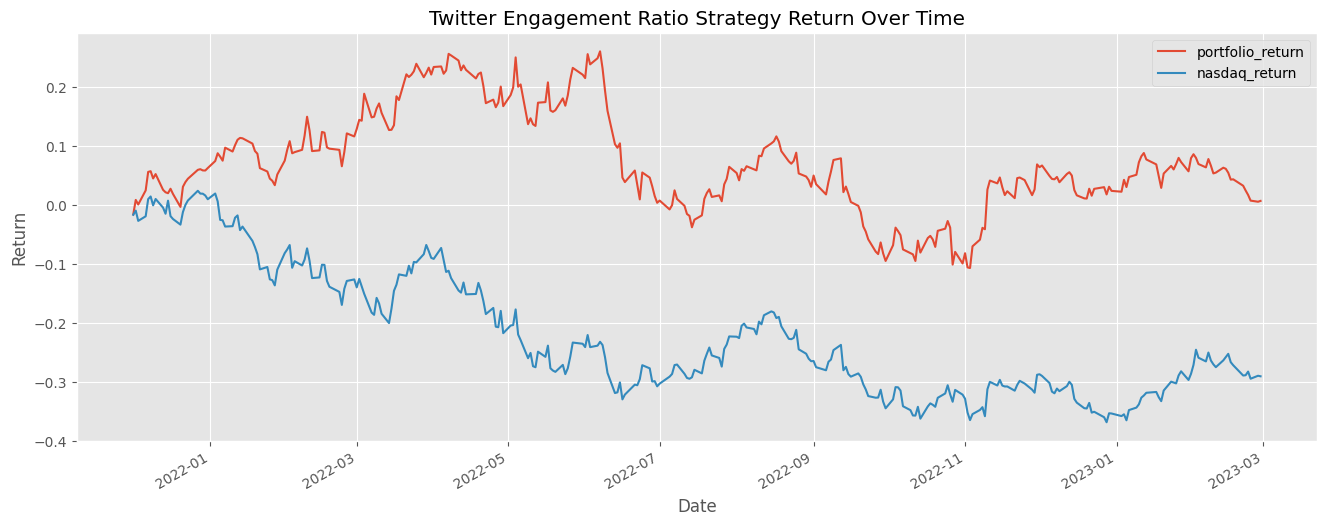

In [113]:
portfolios_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum()).sub(1)
portfolios_cumulative_return.plot(figsize=(16,6))
plt.title('Twitter Engagement Ratio Strategy Return Over Time')
plt.ylabel('Return')

plt.show()